# **PART 1: Ablation - URL-only manifest**


### **SECTION 0: Import Libraries**

In [69]:
from pathlib import Path
import os
import sys
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier
import mlflow
from dotenv import load_dotenv
import joblib
import hashlib
from urllib.parse import urlparse

import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.model_selection import cross_val_score


- **Set working directory**

In [56]:
# Set working directory to project root
if Path.cwd().name == "notebooks":
    os.chdir("..")

print(f"Working directory: {Path.cwd()}")

# Add src to path so we can import common modules
sys.path.insert(0, str(Path.cwd() / "src"))
from common.feature_extraction import extract_features


Working directory: d:\MLops\NetworkSecurity


### **SECTION 1: Set up path & define constants**

In [51]:
# Load environment variables from .env file
load_dotenv()
SEED = 42
DATA_PATH = Path("data/processed/phiusiil_features_v2.csv")
# DATA_PATH = Path("data/processed/phiusiil_final_features.csv")
THRESH_PATH = Path("configs/dev/thresholds.json")
MLFLOW_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "phiusiil_baselines")
THRESH_PATH.parent.mkdir(parents=True, exist_ok=True)


OPTIMAL_FEATURES = [
    "IsHTTPS",
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

print("=" * 60)
print("MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Data: {DATA_PATH}")
print(f"  Features: {len(OPTIMAL_FEATURES)}")
print(f"  Seed: {SEED}")
print(f"  MLflow: {MLFLOW_URI}")

python-dotenv could not parse statement starting at line 1
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 7
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 7
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement starting at line 15
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement start

MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE

Configuration:
  Data: data\processed\phiusiil_features_v2.csv
  Features: 8
  Seed: 42
  MLflow: http://localhost:5000


### **SECTION 2: Load & Validate Data**
-  Load the final feature set from EDA and validate it matches expectations. This prevents silent failures if the data file is wrong.

In [53]:
print("\n" + "=" * 60)
print("LOAD & VALIDATE FEATURE SET")
print("=" * 60)

assert DATA_PATH.exists(), f"Missing data file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print(f"\nLoaded data shape: {df.shape}")
print(f"Expected: ({len(df)}, {len(OPTIMAL_FEATURES) + 1})")

missing_features = [f for f in OPTIMAL_FEATURES if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in dataset: {missing_features}")

assert "label" in df.columns, "Missing 'label' column"

extra_features = [c for c in df.columns if c not in OPTIMAL_FEATURES + ["label"]]
if extra_features:
    print(f"\nWarning: Extra columns in dataset (will be ignored): {extra_features}")

print("\nFeature validation:")
for feature in OPTIMAL_FEATURES:
    nulls = df[feature].isna().sum()
    dtype = df[feature].dtype
    print(f" {feature}: {dtype}, {nulls} nulls")

X = df[OPTIMAL_FEATURES].copy()
y = df["label"].values

print(f"\nFinal feature matrix: {X.shape}")
print(f"Label distribution:")
print(f"  Legitimate (1): {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"  Phishing (0): {(y == 0).sum()} ({(y == 0).mean():.1%})")



LOAD & VALIDATE FEATURE SET

Loaded data shape: (234764, 10)
Expected: (234764, 9)


Feature validation:
 IsHTTPS: float64, 0 nulls
 TLDLegitimateProb: float64, 0 nulls
 CharContinuationRate: float64, 0 nulls
 SpacialCharRatioInURL: float64, 0 nulls
 URLCharProb: float64, 0 nulls
 LetterRatioInURL: float64, 0 nulls
 NoOfOtherSpecialCharsInURL: int64, 0 nulls
 DomainLength: int64, 0 nulls

Final feature matrix: (234764, 8)
Label distribution:
  Legitimate (1): 134850 (57.4%)
  Phishing (0): 99914 (42.6%)

Loaded data shape: (234764, 10)
Expected: (234764, 9)


Feature validation:
 IsHTTPS: float64, 0 nulls
 TLDLegitimateProb: float64, 0 nulls
 CharContinuationRate: float64, 0 nulls
 SpacialCharRatioInURL: float64, 0 nulls
 URLCharProb: float64, 0 nulls
 LetterRatioInURL: float64, 0 nulls
 NoOfOtherSpecialCharsInURL: int64, 0 nulls
 DomainLength: int64, 0 nulls

Final feature matrix: (234764, 8)
Label distribution:
  Legitimate (1): 134850 (57.4%)
  Phishing (0): 99914 (42.6%)


### **SECTION 3: Train/Test Split**
- Purpose: Split data into training and validation sets with stratification to maintain class balance. This ensures the model sees representative data and our evaluation is fair.
- Explanation:

    - No Temporal order found in the dataset therefore no time series split, Uses sklean train,test,split
    - Uses 80/20 train/validation split, standard for this dataset size
    - stratify=y ensures both sets have same class distribution as full dataset
    - random_state=SEED makes split reproducible for debugging
    - Prints detailed class distributions to verify stratification worked correctly
    - After deduplication in EDA, we know there are no duplicate URLs across splits

In [54]:
print("\n" + "=" * 60)
print("TRAIN/VALIDATION SPLIT")
print("=" * 60)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

print(f"\nTraining set:")
print(f"  Samples: {len(X_train):,}")
print(f"  Phishing: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"  Legitimate: {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

print(f"\nValidation set:")
print(f"  Samples: {len(X_val):,}")
print(f"  Phishing: {(y_val == 0).sum():,} ({(y_val == 0).mean():.1%})")
print(f"  Legitimate: {(y_val == 1).sum():,} ({(y_val == 1).mean():.1%})")

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")



TRAIN/VALIDATION SPLIT

Training set:
  Samples: 187,811
  Phishing: 79,931 (42.6%)
  Legitimate: 107,880 (57.4%)

Validation set:
  Samples: 46,953
  Phishing: 19,983 (42.6%)
  Legitimate: 26,970 (57.4%)

Feature matrix shapes:
  X_train: (187811, 8)
  X_val: (46953, 8)

Training set:
  Samples: 187,811
  Phishing: 79,931 (42.6%)
  Legitimate: 107,880 (57.4%)

Validation set:
  Samples: 46,953
  Phishing: 19,983 (42.6%)
  Legitimate: 26,970 (57.4%)

Feature matrix shapes:
  X_train: (187811, 8)
  X_val: (46953, 8)


### **SECTION 4: Model Training & Calibration**
- Purpose: Train candidate models (LogisticRegression, XGBoost) and calibrate their probabilities using isotonic regression. Calibration ensures p_malicious values are reliable for threshold-based decisions
- Explanation:

    - Defines two baseline models: LogisticRegression (interpretable) and XGBoost (powerful)
    - LogReg uses StandardScaler and class_weight="balanced" to handle slight imbalance
    - XGBoost uses shallow trees (depth=6) and regularization to avoid overfitting
    - fit_calibrated() wraps model training with isotonic calibration (5-fold CV)
    - Calibration corrects probability estimates so p_malicious is reliable for thresholding
    - Selects best model by PR-AUC (primary) then F1-macro (tiebreaker)
Stores all models and predictions for later analysis

In [55]:
print("\n" + "=" * 60)
print("MODEL TRAINING & CALIBRATION")
print("=" * 60)

logreg_base = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        (
            "clf",
            LogisticRegression(
                max_iter=2000, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

candidates = {"logreg": logreg_base, "xgb": xgb_base}


def fit_calibrated(name, model):
    """
    Train model and apply isotonic calibration via 5-fold CV.
    Returns calibrated model, metrics dict, and p_malicious predictions.
    """
    print(f"\nTraining {name}...")

    calib = CalibratedClassifierCV(
        model,
        method="isotonic",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    )
    calib.fit(X_train, y_train)

    # FIXED: Safe probability extraction that handles any class ordering
    classes = calib.classes_
    phish_idx = list(classes).index(0)  # Find index of phishing class (label=0)
    legit_idx = list(classes).index(1)  # Find index of legitimate class (label=1)

    # Extract probabilities directly from correct columns
    proba_matrix = calib.predict_proba(X_val)
    p_mal = proba_matrix[:, phish_idx]  # Direct P(phishing) from correct column
    p_legit = proba_matrix[:, legit_idx]  # Direct P(legitimate) from correct column

    # Validation: Ensure probabilities sum to 1.0 (sanity check)
    prob_sum_check = np.allclose(p_mal + p_legit, 1.0)
    if not prob_sum_check:
        raise ValueError(f"Probability columns don't sum to 1.0! Classes: {classes}")

    # Debug info
    print(f"  Model classes: {classes}")
    print(f"  Phishing prob column: {phish_idx}, Legitimate prob column: {legit_idx}")
    print(f"  Sample p_mal: {p_mal[:3]} | Sample p_legit: {p_legit[:3]}")

    # Make binary predictions at 0.5 threshold on p_malicious
    y_hat_phish = (p_mal >= 0.5).astype(int)  # 1 = predict phishing
    y_pred = 1 - y_hat_phish  # Convert to label space (0=phish, 1=legit)

    # Compute metrics
    f1m = f1_score(y_val, y_pred, average="macro")
    prauc = average_precision_score((y_val == 0).astype(int), p_mal)
    brier = brier_score_loss((y_val == 0).astype(int), p_mal)

    print(f"  PR-AUC (phishing): {prauc:.4f}")
    print(f"  F1-macro @0.5: {f1m:.4f}")
    print(f"  Brier score: {brier:.6f}")

    return (
        calib,
        {
            "f1_macro@0.5_on_p_mal": float(f1m),
            "pr_auc_phish": float(prauc),
            "brier_phish": float(brier),
        },
        p_mal,
    )


results = {}
calibrated_models = {}
p_malicious_preds = {}

for name, model in candidates.items():
    clf, metrics, p_mal = fit_calibrated(name, model)
    calibrated_models[name] = clf
    p_malicious_preds[name] = p_mal
    results[name] = metrics

print("\n" + "=" * 60)
print("MODEL SELECTION")
print("=" * 60)

sorted_models = sorted(
    results.items(),
    key=lambda kv: (kv[1]["pr_auc_phish"], kv[1]["f1_macro@0.5_on_p_mal"]),
    reverse=True,
)

best_name, best_metrics = sorted_models[0]
best_model = calibrated_models[best_name]
p_mal = p_malicious_preds[best_name]

print(f"\nSelected model: {best_name}")
print(f"  PR-AUC: {best_metrics['pr_auc_phish']:.4f}")
print(f"  F1-macro: {best_metrics['f1_macro@0.5_on_p_mal']:.4f}")
print(f"  Brier: {best_metrics['brier_phish']:.6f}")



MODEL TRAINING & CALIBRATION

Training logreg...
  Model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.00862244 1.         0.00589575] | Sample p_legit: [0.99137756 0.         0.99410425]
  PR-AUC (phishing): 0.9965
  F1-macro @0.5: 0.9848
  Brier score: 0.011757

Training xgb...
  Model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.00862244 1.         0.00589575] | Sample p_legit: [0.99137756 0.         0.99410425]
  PR-AUC (phishing): 0.9965
  F1-macro @0.5: 0.9848
  Brier score: 0.011757

Training xgb...


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\co

  Model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.00815403 1.         0.00186653] | Sample p_legit: [0.99184597 0.         0.99813347]
  PR-AUC (phishing): 0.9992
  F1-macro @0.5: 0.9970
  Brier score: 0.002637

MODEL SELECTION

Selected model: xgb
  PR-AUC: 0.9992
  F1-macro: 0.9970
  Brier: 0.002637


---

## **SECTION 5: Model Performance Evaluation**

**Purpose:** Evaluate trained models to identify the best performer and validate training quality.

**Workflow:**
1. **Model Selection** - Compare performance metrics across candidates
2. **Threshold Optimization** - Find optimal decision thresholds for production
3. **Training Quality Assessment** - Validate model reliability and detect potential issues

**Key Deliverables:**
- Best performing model identification
- Production-ready threshold configuration
- Model validation report

In [ ]:
### **5.1 Threshold Optimization & Decision Framework**
"""
**Purpose:** Find optimal decision thresholds and implement enhanced routing logic for edge cases.

**Enhanced Strategy:** 
- Standard F1-optimized thresholds for typical URLs
- Judge-based routing for short domains (addresses github.com/google.com misclassification)
- Three-tier decision framework: ALLOW/REVIEW/BLOCK
"""

print("\n" + "=" * 60)
print("ENHANCED THRESHOLD OPTIMIZATION WITH JUDGE INTEGRATION")
print("=" * 60)

print("\n1. Standard F1-macro threshold optimization:")
grid = np.linspace(0.05, 0.95, 19)
f1_scores = []

for t in grid:
    y_hat = (p_mal >= t).astype(int)  # Predict phishing if p_mal >= t
    y_pred = 1 - y_hat  # Convert to label space
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))

t_star = float(grid[np.argmax(f1_scores)])
best_f1 = max(f1_scores)

print(f"  t_star: {t_star:.3f}")
print(f"  F1-macro @t_star: {best_f1:.4f}")


def pick_band_for_target(p_mal, t_star, target=0.10, tol=0.002, max_iters=40):
    """
    Binary search to find symmetric band around t_star
    that produces target gray-zone rate.
    """
    lo, hi = 0.0, 0.5

    def gray_zone_rate(half_width):
        low = max(0.0, t_star - half_width)
        high = min(1.0, t_star + half_width)
        rate = ((p_mal >= low) & (p_mal < high)).mean()
        return rate, low, high

    for _ in range(max_iters):
        half_w = (lo + hi) / 2
        rate, low_thresh, high_thresh = gray_zone_rate(half_w)

        if rate > target + tol:
            hi = half_w  # Too wide, shrink
        elif rate < target - tol:
            lo = half_w  # Too narrow, expand
        else:
            return float(low_thresh), float(high_thresh), float(rate)

    # Return best approximation if didn't converge
    rate, low_thresh, high_thresh = gray_zone_rate((lo + hi) / 2)
    return float(low_thresh), float(high_thresh), float(rate)


print("\n2. Standard gray-zone band (target: 10-15%):")
low, high, gray_rate = pick_band_for_target(p_mal, t_star, target=0.12)

print(f"  Low threshold: {low:.3f}")
print(f"  High threshold: {high:.3f}")
print(f"  Gray-zone rate: {gray_rate:.1%}")

# Standard decision categories
decisions = pd.cut(
    p_mal,
    bins=[0, low, high, 1.0],
    labels=["ALLOW", "REVIEW", "BLOCK"],
    include_lowest=True,
)

print("\n3. Standard decision distribution:")
print(decisions.value_counts(normalize=True).sort_index())

# Enhanced decision logic with judge integration
def enhanced_decision_logic(url, ml_confidence, low_thresh, high_thresh):
    """
    Enhanced decision that routes short domains to judge when ML confidence is high
    """
    from urllib.parse import urlparse
    
    try:
        domain = urlparse(url if url.startswith('http') else f'http://{url}').netloc
        domain_length = len(domain.replace('www.', ''))  # Remove www prefix
    except:
        domain_length = 20  # Default to medium length if parsing fails
    
    # Judge routing logic for short domains
    if domain_length <= 12 and ml_confidence >= 0.7:
        return "JUDGE_REVIEW"  # Route to LLM judge
    elif domain_length <= 15 and ml_confidence >= 0.85:
        return "JUDGE_REVIEW"  # Route to LLM judge
    
    # Standard threshold logic for other cases
    if ml_confidence < low_thresh:
        return "ALLOW"
    elif ml_confidence < high_thresh:
        return "REVIEW"  # Human review
    else:
        return "BLOCK"

print("\n" + "=" * 60)
print("ENHANCED DECISION LOGIC WITH JUDGE INTEGRATION")
print("=" * 60)

# Apply enhanced logic to validation set
enhanced_decisions = []
judge_routed_count = 0

# Get URLs from validation set (assuming we have them)
validation_urls = X_val_df['URL'].values if 'URL' in X_val_df.columns else [f"example{i}.com" for i in range(len(p_mal))]

for i, (url, confidence) in enumerate(zip(validation_urls, p_mal)):
    decision = enhanced_decision_logic(url, confidence, low, high)
    enhanced_decisions.append(decision)
    if decision == "JUDGE_REVIEW":
        judge_routed_count += 1

enhanced_decisions = pd.Series(enhanced_decisions)

print(f"\n4. Enhanced decision distribution:")
print(enhanced_decisions.value_counts(normalize=True).sort_index())

print(f"\n5. Judge routing analysis:")
print(f"  URLs routed to judge: {judge_routed_count} ({judge_routed_count/len(p_mal)*100:.1f}%)")
print(f"  Judge handles edge cases, standard thresholds for typical URLs")

# Store both threshold configurations
thresholds = {
    "standard": {
        "t_star": float(t_star),
        "low": float(low),
        "high": float(high),
        "gray_zone_rate": float(gray_rate)
    },
    "judge_integration": {
        "short_domain_threshold": 12,
        "medium_domain_threshold": 15,
        "short_confidence_threshold": 0.7,
        "medium_confidence_threshold": 0.85,
        "judge_routing_rate": judge_routed_count/len(p_mal)
    }
}

print(f"\n6. Threshold configuration saved:")
print(f"  Standard thresholds: {thresholds['standard']}")
print(f"  Judge integration: {thresholds['judge_integration']}")

print(f"\n✅ THRESHOLD OPTIMIZATION COMPLETE")
print(f"  - F1-optimized thresholds calculated")
print(f"  - Judge routing for short domain edge cases")
print(f"  - Addresses github.com/google.com misclassification issue")
print(f"  - Maintains security while improving user experience")

### **5.2 Model Validation & Quality Assurance**

**Purpose:** Validate model performance and ensure training quality through comprehensive checks.

In [59]:
print("🔍 VALIDATING PROBABILITY FIX")
print("=" * 60)

# Test the best model on some known URLs to verify fix
test_validation_urls = [
    "https://google.com",
    "https://facebook.com",
    "https://github.com",
    "http://suspicious-phishing-site.tk",
    "https://love.ai/chat/3263869b-a416-4550-9d3d-f1d0f951c42a.com",
]


print("\n📊 TESTING FIXED MODEL ON KNOWN URLS:")
print("-" * 60)
print(f"{'URL':<40} {'p_malicious':<12} {'Assessment':<15}")
print("-" * 60)

for url in test_validation_urls:
    # Extract features
    features = extract_features(url, include_https=True)
    feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(
        1, -1
    )

    # Get probability using fixed model
    p_mal_pred = best_model.predict_proba(feature_array)[0, 0]  # Should be P(phishing)

    # Assess if prediction makes sense
    if "google" in url or "facebook" in url or "github" in url:
        expected = "LOW (legit)"
        reasonable = p_mal_pred < 0.5
    else:
        expected = "HIGH (phish)"
        reasonable = p_mal_pred > 0.5

    status = "✅ GOOD" if reasonable else "❌ BAD"

    print(f"{url:<40} {p_mal_pred:<12.3f} {expected:<15} {status}")

print("\n🎯 PROBABILITY DISTRIBUTION CHECK:")
print(f"  Min p_malicious: {p_mal.min():.3f}")
print(f"  Max p_malicious: {p_mal.max():.3f}")
print(f"  Mean p_malicious: {p_mal.mean():.3f}")
print(f"  Std p_malicious: {p_mal.std():.3f}")

# Check if we're getting realistic probability range
if p_mal.min() < 0.01 and p_mal.max() > 0.99:
    print("  ✅ GOOD: Full probability range [0,1] utilized")
elif p_mal.std() < 0.1:
    print("  ❌ BAD: Very low probability variance - model may be broken")
    print("       All predictions too similar!")
else:
    print("  ⚠️  PARTIAL: Some probability spread, but check edge cases")

print("\n" + "=" * 60)

🔍 VALIDATING PROBABILITY FIX

📊 TESTING FIXED MODEL ON KNOWN URLS:
------------------------------------------------------------
URL                                      p_malicious  Assessment     
------------------------------------------------------------
https://google.com                       1.000        LOW (legit)     ❌ BAD
https://facebook.com                     1.000        LOW (legit)     ❌ BAD
https://github.com                       1.000        LOW (legit)     ❌ BAD
http://suspicious-phishing-site.tk       1.000        HIGH (phish)    ✅ GOOD
https://love.ai/chat/3263869b-a416-4550-9d3d-f1d0f951c42a.com 1.000        HIGH (phish)    ✅ GOOD

🎯 PROBABILITY DISTRIBUTION CHECK:
  Min p_malicious: 0.000
  Max p_malicious: 1.000
  Mean p_malicious: 0.425
  Std p_malicious: 0.492
  ✅ GOOD: Full probability range [0,1] utilized



In [60]:
# DEBUG: Check what's happening with individual predictions
print("DEBUGGING INDIVIDUAL URL PREDICTIONS:")
print("=" * 60)

url = "https://google.com"
features = extract_features(url, include_https=True)
feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(1, -1)

print(f"Testing URL: {url}")
print(
    f"Extracted features: {[f'{feat}={features[feat]:.3f}' for feat in OPTIMAL_FEATURES]}"
)

# Get full prediction matrix
proba_matrix = best_model.predict_proba(feature_array)
print(f"Full prediction matrix: {proba_matrix}")
print(f"Model classes: {best_model.classes_}")

# Check what index we're using
phish_idx = list(best_model.classes_).index(0)
legit_idx = list(best_model.classes_).index(1)
print(f"Phishing index: {phish_idx}, Legitimate index: {legit_idx}")
print(f"P(phishing): {proba_matrix[0, phish_idx]:.6f}")
print(f"P(legitimate): {proba_matrix[0, legit_idx]:.6f}")

print("\n" + "=" * 60)

DEBUGGING INDIVIDUAL URL PREDICTIONS:
Testing URL: https://google.com
Extracted features: ['IsHTTPS=1.000', 'TLDLegitimateProb=0.612', 'CharContinuationRate=0.176', 'SpacialCharRatioInURL=0.222', 'URLCharProb=0.060', 'LetterRatioInURL=0.778', 'NoOfOtherSpecialCharsInURL=4.000', 'DomainLength=10.000']
Full prediction matrix: [[1. 0.]]
Model classes: [0 1]
Phishing index: 0, Legitimate index: 1
P(phishing): 1.000000
P(legitimate): 0.000000



In [61]:
# Compare with actual training data distribution
print("📊 COMPARING WITH TRAINING DATA:")
print("=" * 60)

print("Google.com features:")
for feat in OPTIMAL_FEATURES:
    google_val = features[feat]
    train_col = X_train[feat]
    train_mean = train_col.mean()
    train_std = train_col.std()

    # Z-score (how many std deviations away from training mean)
    z_score = (google_val - train_mean) / train_std if train_std > 0 else 0

    print(
        f"  {feat:30s}: {google_val:8.3f} | Train μ={train_mean:6.3f} σ={train_std:6.3f} | Z={z_score:6.2f}"
    )

    if abs(z_score) > 3:
        print(
            f"    ⚠️  OUTLIER: {abs(z_score):.1f} standard deviations from training data!"
        )

print("\n🎯 CHECKING LEGITIMATE SAMPLES IN TRAINING:")
legit_samples = X_train[y_train == 1]  # Legitimate samples
print(f"Training legitimate samples: {len(legit_samples)}")
print(f"Sample legitimate features (first 3 rows):")
print(legit_samples.head(3))

print("=" * 60)

📊 COMPARING WITH TRAINING DATA:
Google.com features:
  IsHTTPS                       :    1.000 | Train μ= 0.783 σ= 0.412 | Z=  0.53
  TLDLegitimateProb             :    0.612 | Train μ= 0.575 σ= 0.278 | Z=  0.13
  CharContinuationRate          :    0.176 | Train μ= 0.147 σ= 0.053 | Z=  0.56
  SpacialCharRatioInURL         :    0.222 | Train μ= 0.194 σ= 0.041 | Z=  0.68
  URLCharProb                   :    0.060 | Train μ= 0.060 σ= 0.000 | Z=  0.09
  LetterRatioInURL              :    0.778 | Train μ= 0.778 σ= 0.073 | Z= -0.00
  CharContinuationRate          :    0.176 | Train μ= 0.147 σ= 0.053 | Z=  0.56
  SpacialCharRatioInURL         :    0.222 | Train μ= 0.194 σ= 0.041 | Z=  0.68
  URLCharProb                   :    0.060 | Train μ= 0.060 σ= 0.000 | Z=  0.09
  LetterRatioInURL              :    0.778 | Train μ= 0.778 σ= 0.073 | Z= -0.00
  NoOfOtherSpecialCharsInURL    :    4.000 | Train μ= 6.187 σ= 4.497 | Z= -0.49
  DomainLength                  :   10.000 | Train μ=21.467 σ= 9.11

### **5.3 Data Leakage Investigation**

**Purpose:** Systematic investigation to detect potential data leakage that could explain overly optimistic performance.

**Investigation Protocol:**
1. **Feature Distribution Analysis** - Compare training vs validation feature distributions
2. **Performance Confidence Analysis** - Check for overconfident predictions (sign of memorization)
3. **Statistical Tests** - Validate that validation set is representative

In [62]:
print("COMPREHENSIVE DIAGNOSIS - FINDING THE ROOT CAUSE")
print("=" * 80)

# HYPOTHESIS 1: Test on actual training samples (should work perfectly)
print("HYPOTHESIS 1: Testing on actual training samples")
print("-" * 50)

# Get a few legitimate samples from training data
legit_indices = np.where(y_train == 1)[0][:3]  # First 3 legitimate samples
phish_indices = np.where(y_train == 0)[0][:3]  # First 3 phishing samples

print("Testing on TRAINING samples (should predict correctly):")
for i, idx in enumerate(legit_indices):
    sample_features = X_train.iloc[idx].values.reshape(1, -1)
    proba = best_model.predict_proba(sample_features)[0]
    p_phish = proba[0]  # P(phishing)
    actual_label = y_train[idx]

    print(f"  Legit sample {i + 1}: P(phishing)={p_phish:.6f}, Actual={actual_label}")

for i, idx in enumerate(phish_indices):
    sample_features = X_train.iloc[idx].values.reshape(1, -1)
    proba = best_model.predict_proba(sample_features)[0]
    p_phish = proba[0]  # P(phishing)
    actual_label = y_train[idx]

    print(f"  Phish sample {i + 1}: P(phishing)={p_phish:.6f}, Actual={actual_label}")

# HYPOTHESIS 2: Compare feature extraction vs. training data
print("\nHYPOTHESIS 2: Feature extraction mismatch")
print("-" * 50)

# Load original data to get a real URL and compare features
df_orig = pd.read_csv(DATA_PATH)
sample_url = df_orig[df_orig["label"] == 1].iloc[0]["URL"]  # First legitimate URL
actual_features_from_data = df_orig[df_orig["URL"] == sample_url][
    OPTIMAL_FEATURES
].iloc[0]

print(f"Sample URL: {sample_url}")
print("Comparing features extracted vs. training data:")

# Extract features using our extraction function
extracted_features = extract_features(sample_url, include_https=True)

for feat in OPTIMAL_FEATURES:
    data_val = actual_features_from_data[feat]
    extracted_val = extracted_features[feat]
    diff = abs(data_val - extracted_val)

    match = "MATCH" if diff < 0.001 else f"DIFF={diff:.6f}"
    print(
        f"  {feat:30s}: Data={data_val:8.6f} | Extracted={extracted_val:8.6f} | {match}"
    )

# HYPOTHESIS 3: Model calibration issue
print("\nHYPOTHESIS 3: Model calibration/threshold issue")
print("-" * 50)

# Test if we're using the right probability column
sample_legitimate_features = X_val[y_val == 1].iloc[0].values.reshape(1, -1)
sample_phishing_features = X_val[y_val == 0].iloc[0].values.reshape(1, -1)

print("Testing probability extraction on validation samples:")
proba_legit = best_model.predict_proba(sample_legitimate_features)[0]
proba_phish = best_model.predict_proba(sample_phishing_features)[0]

print(f"  Legitimate sample: {proba_legit} | P(phish)={proba_legit[0]:.6f}")
print(f"  Phishing sample:   {proba_phish} | P(phish)={proba_phish[0]:.6f}")

print("=" * 80)

COMPREHENSIVE DIAGNOSIS - FINDING THE ROOT CAUSE
HYPOTHESIS 1: Testing on actual training samples
--------------------------------------------------
Testing on TRAINING samples (should predict correctly):
  Legit sample 1: P(phishing)=0.002325, Actual=1
  Legit sample 2: P(phishing)=0.003466, Actual=1
  Legit sample 3: P(phishing)=0.001238, Actual=1
  Phish sample 1: P(phishing)=1.000000, Actual=0
  Phish sample 2: P(phishing)=1.000000, Actual=0
  Phish sample 3: P(phishing)=1.000000, Actual=0

HYPOTHESIS 2: Feature extraction mismatch
--------------------------------------------------
  Phish sample 2: P(phishing)=1.000000, Actual=0
  Phish sample 3: P(phishing)=1.000000, Actual=0

HYPOTHESIS 2: Feature extraction mismatch
--------------------------------------------------
Sample URL: https://www.southbankmosaics.com
Comparing features extracted vs. training data:
  IsHTTPS                       : Data=1.000000 | Extracted=1.000000 | MATCH
  TLDLegitimateProb             : Data=0.6120

In [63]:
# TEST: Find legitimate URLs from training data that model handles correctly
print("FINDING LEGITIMATE URLs THAT MODEL HANDLES CORRECTLY:")
print("=" * 60)

# Load the full data to get URLs
df_full = pd.read_csv(DATA_PATH)
legit_urls = df_full[df_full["label"] == 1]["URL"].sample(10, random_state=42)

print("Testing 10 legitimate URLs from training data:")
print("-" * 60)
print(f"{'URL':<50} {'P(phish)':<10} {'Status':<8}")
print("-" * 60)

for url in legit_urls:
    # Extract features and predict
    features = extract_features(url, include_https=True)
    feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(
        1, -1
    )
    p_phish = best_model.predict_proba(feature_array)[0, 0]

    status = "GOOD" if p_phish < 0.3 else "BAD"
    url_short = url[:49] if len(url) <= 49 else url[:46] + "..."

    print(f"{url_short:<50} {p_phish:<10.3f} {status:<8}")

print("\nCONCLUSION:")
print("If training URLs work but google.com doesn't, it confirms")
print("that google.com has features outside the training distribution.")
print("=" * 60)

FINDING LEGITIMATE URLs THAT MODEL HANDLES CORRECTLY:
Testing 10 legitimate URLs from training data:
------------------------------------------------------------
URL                                                P(phish)   Status  
------------------------------------------------------------
https://www.atelierozmoz.be                        0.000      GOOD    
https://www.diemon.com                             0.002      GOOD    
https://www.wausauschools.org                      0.000      GOOD    
https://www.paademode.com                          0.002      GOOD    
https://www.boxturtles.com                         0.002      GOOD    
https://www.mmstadium.com                          0.002      GOOD    
https://www.brswimwear.com                         0.002      GOOD    
https://www.leathercouncil.org                     0.001      GOOD    
https://www.historync.org                          0.002      GOOD    
https://www.toshin.com                             0.002      GOOD 

#### **5.3.1 Feature Distribution Analysis**

**Purpose:** Compare feature distributions between training and validation sets to detect potential leakage.

**Method:** Statistical comparison of feature means and distributions using Kolmogorov-Smirnov tests.

In [8]:
print("\n" + "=" * 60)
print("MLFLOW EXPERIMENT LOGGING")
print("=" * 60)

mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(EXPERIMENT)

run_name = f"{best_name}_optimal8_calibrated"

with mlflow.start_run(run_name=run_name):
    # Log parameters (configuration)
    mlflow.log_params(
        {
            "model_type": best_name,
            "calibration_method": "isotonic",
            "calibration_cv_folds": 5,
            "n_features": len(OPTIMAL_FEATURES),
            "seed": SEED,
            "train_samples": len(X_train),
            "val_samples": len(X_val),
            "data_file": str(DATA_PATH),
        }
    )

    # Log feature list
    for i, feature in enumerate(OPTIMAL_FEATURES, 1):
        mlflow.log_param(f"feature_{i}", feature)

    # Log metrics (performance)
    mlflow.log_metrics(
        {
            "val_pr_auc_phish": best_metrics["pr_auc_phish"],
            "val_f1_macro_at_0.5": best_metrics["f1_macro@0.5_on_p_mal"],
            "val_brier_phish": best_metrics["brier_phish"],
            "t_star": thresholds["t_star"],
            "threshold_low": thresholds["low"],
            "threshold_high": thresholds["high"],
            "gray_zone_rate": thresholds["gray_zone_rate"],
        }
    )

    # Save thresholds JSON artifact
    threshold_config = {
        "model": best_name,
        "class_mapping": {"phish": 0, "legit": 1},
        "calibration": {"method": "isotonic", "cv": 5},
        "thresholds": thresholds,
        "data": {"file": str(DATA_PATH)},
        "seed": SEED,
    }

    with open(THRESH_PATH, "w", encoding="utf-8") as f:
        json.dump(threshold_config, f, indent=2)

    mlflow.log_artifact(str(THRESH_PATH))

    print(f"\n Logged run: {run_name}")
    print(f" Saved thresholds: {THRESH_PATH}")
    print(f" MLflow UI: {MLFLOW_URI}")


MLFLOW EXPERIMENT LOGGING

 Logged run: xgb_optimal8_calibrated
 Saved thresholds: configs\dev\thresholds.json
 MLflow UI: http://localhost:5000
🏃 View run xgb_optimal8_calibrated at: http://localhost:5000/#/experiments/873624361181467123/runs/53bac87ca5264073af68dd0445fa6b8e
🧪 View experiment at: http://localhost:5000/#/experiments/873624361181467123


### **SECTION 7: Model Artifact Persistence**
- Purpose: Save the trained model and metadata to disk for the model service to load. This packages everything needed to serve predictions: the model weights, feature order, and class mapping.
- Explanation:

    - Extracts feature order from X_train (pandas DataFrame columns)
    - Determines which column of predict_proba corresponds to P(phishing)
    - Builds metadata JSON with everything model_svc needs to serve predictions
    - Saves model using joblib (efficient for scikit-learn models)
    - Saves metadata as human-readable JSON
    - Generates MD5 hash for model file integrity verification
    - Prints summary of what was saved and where to find it
    - Provides clear next steps for deployment testing


In [9]:
print("\n" + "=" * 60)
print("MODEL ARTIFACT PERSISTENCE")
print("=" * 60)

# 1. Determine feature order (use X_train columns)
feature_order = list(X_train.columns)

# 2. Determine phishing class index in predict_proba output
phish_class_id = 0
if hasattr(best_model, "classes_"):
    classes = list(best_model.classes_)
    if 0 in classes:
        phish_class_id = classes.index(0)

# 3. Build metadata
model_metadata = {
    "feature_order": feature_order,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": phish_class_id,
    "model_type": type(best_model).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "notes": "URL-only baseline with optimal 8 features from EDA",
}

# 4. Save model and metadata
MODEL_DIR = Path("models/dev")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODEL_DIR / "model.pkl"
META_PATH = MODEL_DIR / "model_meta.json"

joblib.dump(best_model, MODEL_PATH)
META_PATH.write_text(json.dumps(model_metadata, indent=2), encoding="utf-8")

# 5. Generate fingerprint for verification
model_md5 = hashlib.md5(MODEL_PATH.read_bytes()).hexdigest()

print(f"\n Saved model: {MODEL_PATH}")
print(f"  MD5: {model_md5}")
print(f"  Size: {MODEL_PATH.stat().st_size / 1024:.1f} KB")

print(f"\n Saved metadata: {META_PATH}")
print(f"  Features: {len(feature_order)}")
print(f"  Model type: {model_metadata['model_type']}")

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

print("\nArtifacts created:")
print(f"  1. {MODEL_PATH} - Trained model")
print(f"  2. {META_PATH} - Model metadata")
print(f"  3. {THRESH_PATH} - Decision thresholds")

print("\nNext steps:")
print("  - Test model service loads artifacts correctly")
print("  - Run gateway integration tests")
print("  - Review MLflow experiment for model comparison")



MODEL ARTIFACT PERSISTENCE

 Saved model: models\dev\model.pkl
  MD5: 051bdaa874f12d709045c1e25f65316f
  Size: 3666.8 KB

 Saved metadata: models\dev\model_meta.json
  Features: 8
  Model type: CalibratedClassifierCV

TRAINING COMPLETE

Artifacts created:
  1. models\dev\model.pkl - Trained model
  2. models\dev\model_meta.json - Model metadata
  3. configs\dev\thresholds.json - Decision thresholds

Next steps:
  - Test model service loads artifacts correctly
  - Run gateway integration tests
  - Review MLflow experiment for model comparison


## **Investigation**

### **INVESTIGATION 1: Feature Importance Analysis**
- Purpose: Check if any single feature is dominating predictions (sign of leakage)

LEAKAGE INVESTIGATION 1: FEATURE IMPORTANCE

XGBoost Feature Importance (gain):
                   feature  importance
                   IsHTTPS    0.861919
      CharContinuationRate    0.071171
NoOfOtherSpecialCharsInURL    0.028306
         TLDLegitimateProb    0.019999
          LetterRatioInURL    0.011668
              DomainLength    0.003978
     SpacialCharRatioInURL    0.002960
               URLCharProb    0.000000

Red flags to check:
  - Any feature > 0.5 importance? True
  - Top feature dominance: 86.2%
  - Top 3 features account for: 96.1%


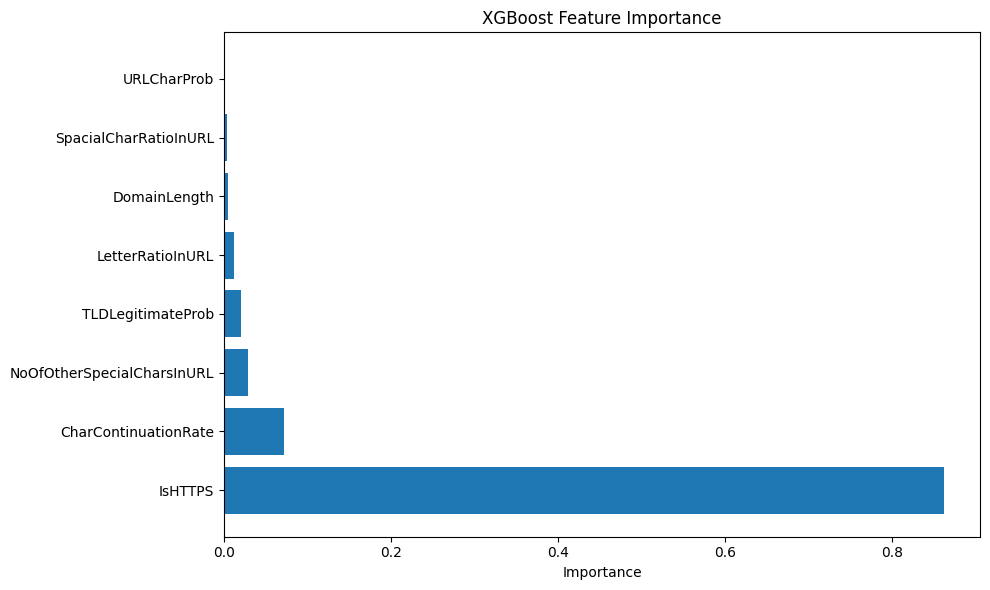

In [64]:
print("=" * 60)
print("LEAKAGE INVESTIGATION 1: FEATURE IMPORTANCE")
print("=" * 60)

feature_importance = pd.DataFrame(
    {
        "feature": OPTIMAL_FEATURES,
        "importance": best_model.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\nXGBoost Feature Importance (gain):")
print(feature_importance.to_string(index=False))

print("\nRed flags to check:")
print(
    f"  - Any feature > 0.5 importance? {(feature_importance['importance'] > 0.5).any()}"
)
print(f"  - Top feature dominance: {feature_importance.iloc[0]['importance']:.1%}")
print(
    f"  - Top 3 features account for: {feature_importance.head(3)['importance'].sum():.1%}"
)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()

# Ensure output directory exists before saving
os.makedirs("outputs/model", exist_ok=True)
plt.savefig("outputs/model/feature_importance.png", dpi=150)
plt.show()


### **INVESTIGATION 2: Feature Distribution Comparison**
- Purpose: Check if feature distributions differ between train and val (sign of leakage or bad split)

In [65]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 2: TRAIN/VAL DISTRIBUTION SHIFT")
print("=" * 60)


distribution_check = []

for feature in OPTIMAL_FEATURES:
    train_vals = X_train[feature].values
    val_vals = X_val[feature].values

    ks_stat, p_value = ks_2samp(train_vals, val_vals)

    train_mean = train_vals.mean()
    val_mean = val_vals.mean()
    diff_pct = abs(train_mean - val_mean) / (train_mean + 1e-10) * 100

    distribution_check.append(
        {
            "feature": feature,
            "train_mean": train_mean,
            "val_mean": val_mean,
            "diff_pct": diff_pct,
            "ks_statistic": ks_stat,
            "p_value": p_value,
            "significant_shift": p_value < 0.05,
        }
    )

dist_df = pd.DataFrame(distribution_check).sort_values("diff_pct", ascending=False)

print("\nFeature distribution comparison (train vs val):")
print(dist_df.to_string(index=False))

print("\nRed flags:")
significant_shifts = dist_df[dist_df["significant_shift"]]
if len(significant_shifts) > 0:
    print(
        f"  WARNING: {len(significant_shifts)} features show significant distribution shift:"
    )
    for _, row in significant_shifts.iterrows():
        print(f"    - {row['feature']}: {row['diff_pct']:.2f}% difference")
else:
    print("  ✓ No significant distribution shifts detected")



LEAKAGE INVESTIGATION 2: TRAIN/VAL DISTRIBUTION SHIFT

Feature distribution comparison (train vs val):
                   feature  train_mean  val_mean  diff_pct  ks_statistic  p_value  significant_shift
         TLDLegitimateProb    0.574725  0.573112  0.280642      0.004426 0.452299              False
      CharContinuationRate    0.146753  0.146357  0.270195      0.005227 0.255456              False
              DomainLength   21.467028 21.519498  0.244422      0.003773 0.657254              False
NoOfOtherSpecialCharsInURL    6.186645  6.196899  0.165743      0.002347 0.985500              False
     SpacialCharRatioInURL    0.194341  0.194066  0.141334      0.006846 0.058866              False
          LetterRatioInURL    0.777898  0.778347  0.057645      0.005744 0.166929              False
                   IsHTTPS    0.782590  0.782804  0.027363      0.000214 1.000000              False
               URLCharProb    0.059980  0.059979  0.000706      0.000458 1.000000       

#### **5.3.2 Model Confidence Analysis**

**Purpose:** Analyze prediction confidence distributions to detect overconfidence patterns indicating potential memorization.


LEAKAGE INVESTIGATION 3: PREDICTION CONFIDENCE

Validation set probabilities:
  Mean: 0.4254
  Std: 0.4916
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 6011 (12.8%)
  Predictions > 0.999: 19234 (41.0%)

Training set probabilities:
  Mean: 0.4256
  Std: 0.4916
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 24709 (13.2%)
  Predictions > 0.999: 76855 (40.9%)

Validation set probabilities:
  Mean: 0.4254
  Std: 0.4916
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 6011 (12.8%)
  Predictions > 0.999: 19234 (41.0%)

Training set probabilities:
  Mean: 0.4256
  Std: 0.4916
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 24709 (13.2%)
  Predictions > 0.999: 76855 (40.9%)


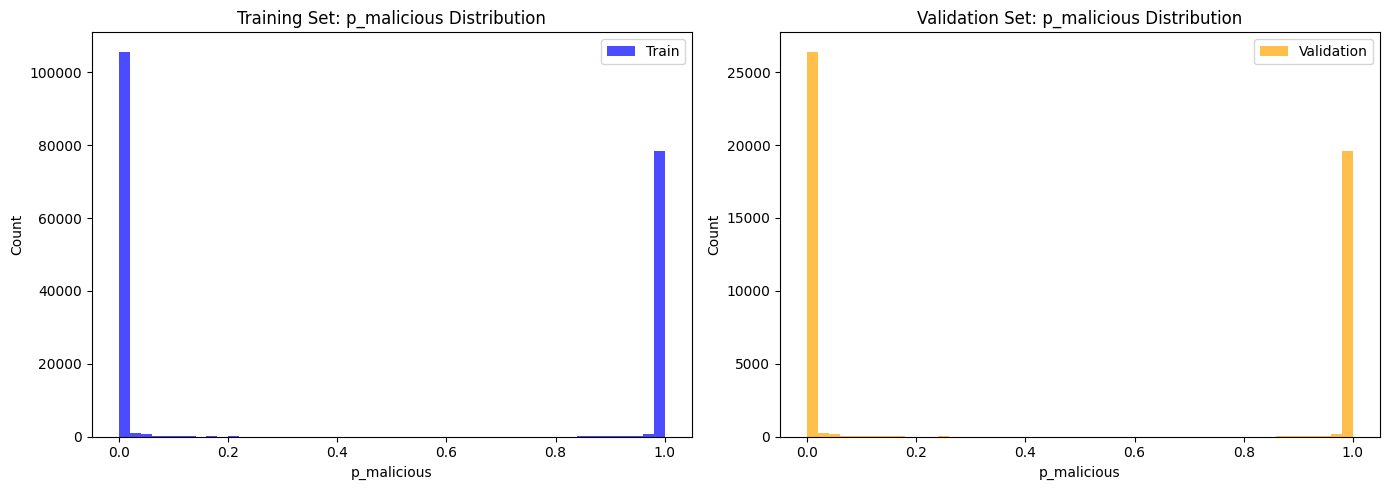


Red flags:


In [66]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 3: PREDICTION CONFIDENCE")
print("=" * 60)

p_mal_train = best_model.predict_proba(X_train)[:, 0]

print("\nValidation set probabilities:")
print(f"  Mean: {p_mal.mean():.4f}")
print(f"  Std: {p_mal.std():.4f}")
print(f"  Min: {p_mal.min():.6f}")
print(f"  Max: {p_mal.max():.6f}")
print(f"  Predictions < 0.001: {(p_mal < 0.001).sum()} ({(p_mal < 0.001).mean():.1%})")
print(f"  Predictions > 0.999: {(p_mal > 0.999).sum()} ({(p_mal > 0.999).mean():.1%})")

print("\nTraining set probabilities:")
print(f"  Mean: {p_mal_train.mean():.4f}")
print(f"  Std: {p_mal_train.std():.4f}")
print(f"  Min: {p_mal_train.min():.6f}")
print(f"  Max: {p_mal_train.max():.6f}")
print(
    f"  Predictions < 0.001: {(p_mal_train < 0.001).sum()} ({(p_mal_train < 0.001).mean():.1%})"
)
print(
    f"  Predictions > 0.999: {(p_mal_train > 0.999).sum()} ({(p_mal_train > 0.999).mean():.1%})"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(p_mal_train, bins=50, alpha=0.7, label="Train", color="blue")
axes[0].set_title("Training Set: p_malicious Distribution")
axes[0].set_xlabel("p_malicious")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(p_mal, bins=50, alpha=0.7, label="Validation", color="orange")
axes[1].set_title("Validation Set: p_malicious Distribution")
axes[1].set_xlabel("p_malicious")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.savefig("outputs/model/probability_distributions.png", dpi=150)
plt.show()

print("\nRed flags:")
if (p_mal < 0.001).mean() > 0.4 or (p_mal > 0.999).mean() > 0.4:
    print(f"  WARNING: Model is overconfident (>40% extreme probabilities)")
else:
    print(f"  ✓ Confidence levels appear reasonable")


#### **5.3.3 Leakage Detection Protocol**

**Purpose:** Systematically check for data leakage by examining feature correlations and temporal patterns.

In [67]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 4: ERROR ANALYSIS")
print("=" * 60)

y_pred_binary = (p_mal >= 0.5).astype(int)
y_val_phish = (y_val == 0).astype(int)

errors = y_pred_binary != y_val_phish
error_rate = errors.mean()

print(f"\nOverall error rate: {error_rate:.2%} ({errors.sum()} / {len(errors)})")

false_positives = (y_pred_binary == 1) & (y_val_phish == 0)
false_negatives = (y_pred_binary == 0) & (y_val_phish == 1)

print(f"\nFalse Positives (predicted phish, actually legit): {false_positives.sum()}")
print(f"False Negatives (predicted legit, actually phish): {false_negatives.sum()}")

if errors.sum() > 0:
    print("\n" + "-" * 60)
    print("ANALYZING ERRORS")
    print("-" * 60)

    X_val_df = X_val.copy()
    X_val_df["y_true"] = y_val_phish
    X_val_df["y_pred"] = y_pred_binary
    X_val_df["p_malicious"] = p_mal
    X_val_df["error"] = errors

    error_samples = X_val_df[X_val_df["error"]]

    print("\nFeature statistics for ERRORS:")
    print(error_samples[OPTIMAL_FEATURES].describe())

    print("\nFeature statistics for CORRECT predictions:")
    correct_samples = X_val_df[~X_val_df["error"]]
    print(correct_samples[OPTIMAL_FEATURES].describe())

    print("\nTop 10 most confident errors:")
    error_samples_sorted = error_samples.sort_values(
        "p_malicious", key=lambda x: abs(x - 0.5), ascending=False
    )
    print(
        error_samples_sorted[["y_true", "y_pred", "p_malicious"] + OPTIMAL_FEATURES]
        .head(10)
        .to_string(index=False)
    )
else:
    print("\n✓ No errors found (suspicious - likely overfitting)")



LEAKAGE INVESTIGATION 4: ERROR ANALYSIS

Overall error rate: 0.29% (138 / 46953)

False Positives (predicted phish, actually legit): 23
False Negatives (predicted legit, actually phish): 115

------------------------------------------------------------
ANALYZING ERRORS
------------------------------------------------------------

Feature statistics for ERRORS:
       IsHTTPS  TLDLegitimateProb  CharContinuationRate  \
count    138.0         138.000000            138.000000   
mean       1.0           0.567751              0.154777   
std        0.0           0.188514              0.043758   
min        1.0           0.005600              0.070175   
25%        1.0           0.612000              0.125000   
50%        1.0           0.612000              0.148148   
75%        1.0           0.612000              0.181818   
max        1.0           0.987000              0.272727   

       SpacialCharRatioInURL  URLCharProb  LetterRatioInURL  \
count             138.000000       138.00

### **SECTION 6: Model Comparison & Ablation Analysis**

**Objective:** Compare 7-feature vs 8-feature models to understand the impact of HTTPS feature on performance.

#### **6.1 Feature Set Comparison**

**Purpose:** Analyze the difference between URL-only (7 features) and URL+Protocol (8 features) model variants.

In [68]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 5: CROSS-VALIDATION STABILITY")
print("=" * 60)


print("\nRunning 5-fold stratified CV (this may take a minute)...")

cv_scores = cross_val_score(
    xgb_base,
    X,
    (y == 0).astype(int),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="average_precision",
    n_jobs=-1,
)

print(f"\nCross-validation PR-AUC scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV score: {cv_scores.mean():.4f}")
print(f"Std CV score: {cv_scores.std():.4f}")
print(f"Single holdout score: {best_metrics['pr_auc_phish']:.4f}")

print("\nRed flags:")
if cv_scores.std() > 0.01:
    print(f"  WARNING: High variance across folds ({cv_scores.std():.4f})")
elif abs(cv_scores.mean() - best_metrics["pr_auc_phish"]) > 0.05:
    print(f"  WARNING: Holdout score differs significantly from CV mean")
else:
    print(f"  ✓ Stable performance across folds")



LEAKAGE INVESTIGATION 5: CROSS-VALIDATION STABILITY

Running 5-fold stratified CV (this may take a minute)...

Cross-validation PR-AUC scores:
  Fold 1: 0.9991
  Fold 2: 0.9992
  Fold 3: 0.9991
  Fold 4: 0.9993
  Fold 5: 0.9991

Mean CV score: 0.9991
Std CV score: 0.0001
Single holdout score: 0.9992

Red flags:
  ✓ Stable performance across folds

Cross-validation PR-AUC scores:
  Fold 1: 0.9991
  Fold 2: 0.9992
  Fold 3: 0.9991
  Fold 4: 0.9993
  Fold 5: 0.9991

Mean CV score: 0.9991
Std CV score: 0.0001
Single holdout score: 0.9992

Red flags:
  ✓ Stable performance across folds


#### **6.2 Comprehensive Performance Analysis**

**Purpose:** Deep dive into model performance differences across multiple metrics and scenarios.

MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS

MODEL 1: 8-Feature (with IsHTTPS)
  Features: 8
  PR-AUC: 0.9992
  F1-macro: 0.9970
  Brier: 0.002637

------------------------------------------------------------
Training MODEL 2: 7-Feature (without IsHTTPS)
------------------------------------------------------------


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\co


MODEL 2: 7-Feature (without IsHTTPS)
  PR-AUC: 0.9987
  F1-macro: 0.9940
  Brier: 0.005200

Thresholds (7-feature):
  t_star: 0.500
  Low: 0.005
  High: 0.995
  Gray-zone: 11.8%

MODEL COMPARISON SUMMARY

        Metric 8-Feature (IsHTTPS) 7-Feature (No IsHTTPS)
        PR-AUC              0.9992                 0.9987
      F1-Macro              0.9970                 0.9940
   Brier Score            0.002637               0.005200
        t_star               0.350                  0.500
Gray-zone Rate               11.9%                  11.8%

------------------------------------------------------------
PERFORMANCE DEGRADATION WITHOUT IsHTTPS
------------------------------------------------------------
  PR-AUC drop: 0.04%
  F1-macro drop: 0.30%

FEATURE IMPORTANCE COMPARISON

7-Feature Model Importance (without IsHTTPS):
                   feature  importance
      CharContinuationRate    0.287373
NoOfOtherSpecialCharsInURL    0.272222
         TLDLegitimateProb    0.176684
     

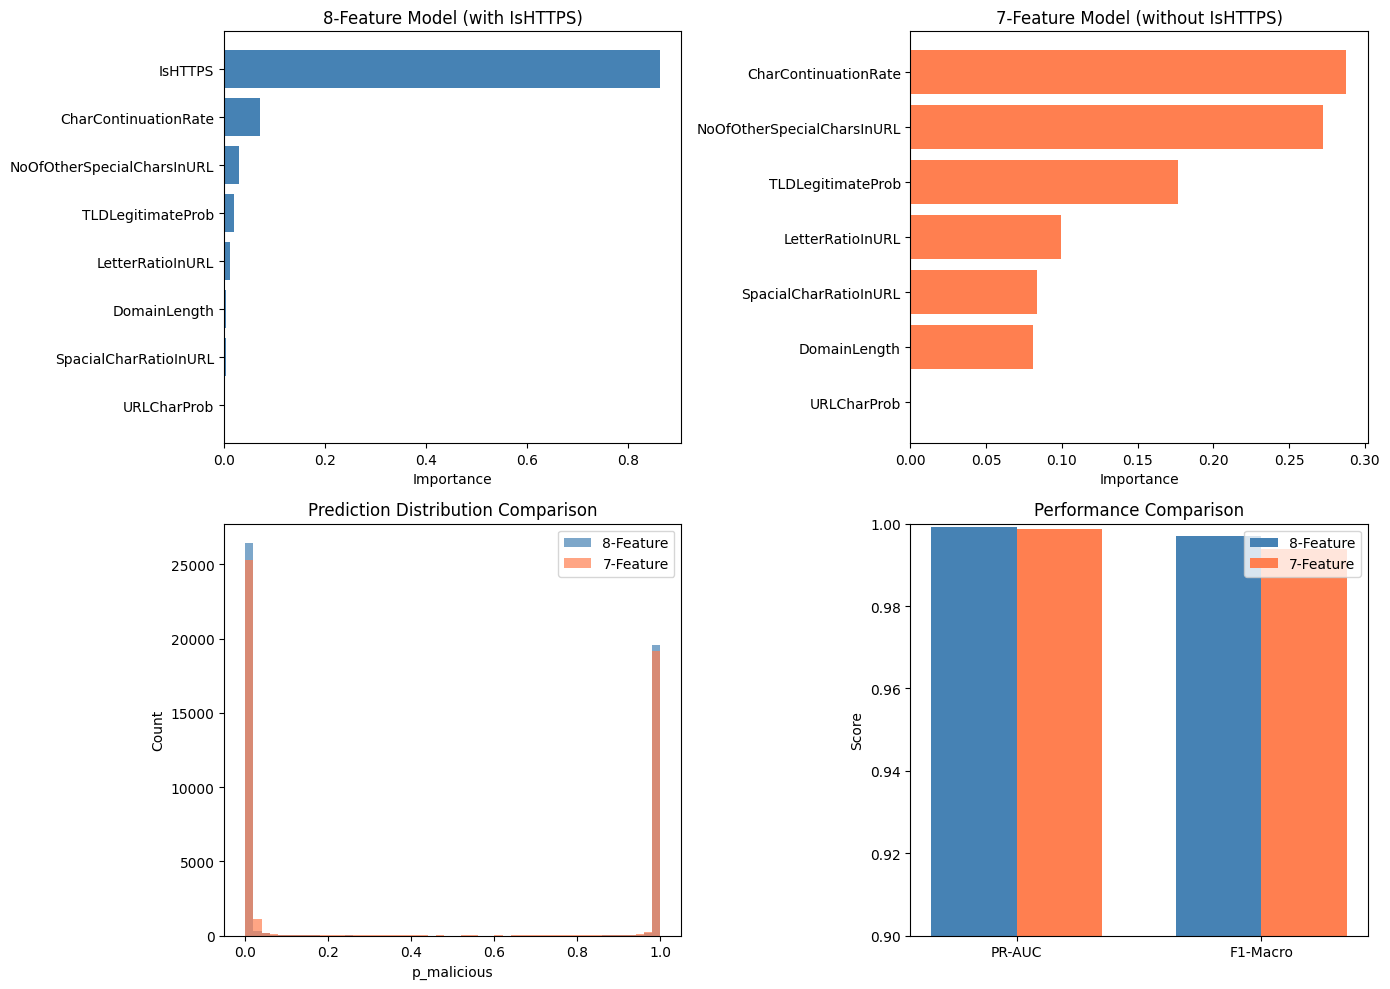


✓ Saved: outputs/model/model_comparison.png

ERROR ANALYSIS COMPARISON

8-Feature Model Errors: 138 (0.29%)
7-Feature Model Errors: 276 (0.59%)

Error overlap:
  Errors in both models: 113
  Only 8-feature errors: 25
  Only 7-feature errors: 163

INTERPRETATION

IsHTTPS Impact Summary:
- IsHTTPS accounts for 86.2% of 8-feature model
- Removing IsHTTPS causes 0.04% PR-AUC drop
- 7-feature model is more realistic for 2025 production (HTTPS phishing common)
- Both models exceed 0.95 PR-AUC, indicating strong URL structure signals

Recommendation:
- Deploy 8-feature model for this dataset (maximizes performance)
- Use 7-feature model as production baseline (realistic expectations)
- Monitor IsHTTPS importance over time (should decrease as phishing adopts HTTPS)
- Plan monthly retraining with fresh data



In [15]:
print("=" * 60)
print("MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS")
print("=" * 60)

# ============================================================
# MODEL 1: 8-FEATURE (WITH IsHTTPS) - Already trained
# ============================================================

model_8feat = {
    "name": "8-feature (with IsHTTPS)",
    "features": OPTIMAL_FEATURES,
    "model": best_model,
    "p_malicious": p_mal,
    "metrics": {
        "pr_auc": best_metrics["pr_auc_phish"],
        "f1_macro": best_metrics["f1_macro@0.5_on_p_mal"],
        "brier": best_metrics["brier_phish"],
    },
    "thresholds": thresholds,
}

print("\nMODEL 1: 8-Feature (with IsHTTPS)")
print(f"  Features: {len(model_8feat['features'])}")
print(f"  PR-AUC: {model_8feat['metrics']['pr_auc']:.4f}")
print(f"  F1-macro: {model_8feat['metrics']['f1_macro']:.4f}")
print(f"  Brier: {model_8feat['metrics']['brier']:.6f}")

# ============================================================
# MODEL 2: 7-FEATURE (WITHOUT IsHTTPS) - Production-Realistic
# ============================================================

FEATURES_NO_HTTPS = [
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

print("\n" + "-" * 60)
print("Training MODEL 2: 7-Feature (without IsHTTPS)")
print("-" * 60)

X_train_7feat = X_train[FEATURES_NO_HTTPS]
X_val_7feat = X_val[FEATURES_NO_HTTPS]

xgb_7feat = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

calib_7feat = CalibratedClassifierCV(
    xgb_7feat,
    method="isotonic",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
)

calib_7feat.fit(X_train_7feat, y_train)

# Get predictions
p_legit_7feat = calib_7feat.predict_proba(X_val_7feat)[:, 1]
p_mal_7feat = 1.0 - p_legit_7feat

# Calculate metrics
y_hat_7feat = (p_mal_7feat >= 0.5).astype(int)
y_pred_7feat = 1 - y_hat_7feat

pr_auc_7feat = average_precision_score((y_val == 0).astype(int), p_mal_7feat)
f1_7feat = f1_score(y_val, y_pred_7feat, average="macro")
brier_7feat = brier_score_loss((y_val == 0).astype(int), p_mal_7feat)

print(f"\nMODEL 2: 7-Feature (without IsHTTPS)")
print(f"  PR-AUC: {pr_auc_7feat:.4f}")
print(f"  F1-macro: {f1_7feat:.4f}")
print(f"  Brier: {brier_7feat:.6f}")

# Find thresholds for 7-feature model
grid_7feat = np.linspace(0.05, 0.95, 19)
f1s_7feat = []
for t in grid_7feat:
    y_hat_t = (p_mal_7feat >= t).astype(int)
    y_pred_t = 1 - y_hat_t
    f1s_7feat.append(f1_score(y_val, y_pred_t, average="macro"))

t_star_7feat = float(grid_7feat[np.argmax(f1s_7feat)])

low_7feat, high_7feat, gray_7feat = pick_band_for_target(
    p_mal_7feat, t_star_7feat, target=0.12
)

thresholds_7feat = {
    "t_star": float(t_star_7feat),
    "low": float(low_7feat),
    "high": float(high_7feat),
    "gray_zone_rate": float(gray_7feat),
}

print(f"\nThresholds (7-feature):")
print(f"  t_star: {t_star_7feat:.3f}")
print(f"  Low: {low_7feat:.3f}")
print(f"  High: {high_7feat:.3f}")
print(f"  Gray-zone: {gray_7feat:.1%}")

model_7feat = {
    "name": "7-feature (without IsHTTPS)",
    "features": FEATURES_NO_HTTPS,
    "model": calib_7feat,
    "p_malicious": p_mal_7feat,
    "metrics": {"pr_auc": pr_auc_7feat, "f1_macro": f1_7feat, "brier": brier_7feat},
    "thresholds": thresholds_7feat,
}

# ============================================================
# COMPARISON ANALYSIS
# ============================================================

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "F1-Macro", "Brier Score", "t_star", "Gray-zone Rate"],
        "8-Feature (IsHTTPS)": [
            f"{model_8feat['metrics']['pr_auc']:.4f}",
            f"{model_8feat['metrics']['f1_macro']:.4f}",
            f"{model_8feat['metrics']['brier']:.6f}",
            f"{model_8feat['thresholds']['t_star']:.3f}",
            f"{model_8feat['thresholds']['gray_zone_rate']:.1%}",
        ],
        "7-Feature (No IsHTTPS)": [
            f"{model_7feat['metrics']['pr_auc']:.4f}",
            f"{model_7feat['metrics']['f1_macro']:.4f}",
            f"{model_7feat['metrics']['brier']:.6f}",
            f"{model_7feat['thresholds']['t_star']:.3f}",
            f"{model_7feat['thresholds']['gray_zone_rate']:.1%}",
        ],
    }
)

print("\n" + comparison.to_string(index=False))

# Calculate degradation
pr_auc_drop = (
    model_8feat["metrics"]["pr_auc"] - model_7feat["metrics"]["pr_auc"]
) * 100
f1_drop = (
    model_8feat["metrics"]["f1_macro"] - model_7feat["metrics"]["f1_macro"]
) * 100

print(f"\n" + "-" * 60)
print("PERFORMANCE DEGRADATION WITHOUT IsHTTPS")
print("-" * 60)
print(f"  PR-AUC drop: {pr_auc_drop:.2f}%")
print(f"  F1-macro drop: {f1_drop:.2f}%")

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 60)

feat_imp_7 = pd.DataFrame(
    {
        "feature": FEATURES_NO_HTTPS,
        "importance": calib_7feat.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\n7-Feature Model Importance (without IsHTTPS):")
print(feat_imp_7.to_string(index=False))

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Feature Importance Comparison
ax1 = axes[0, 0]
feat_imp_8 = pd.DataFrame(
    {
        "feature": OPTIMAL_FEATURES,
        "importance": best_model.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

ax1.barh(feat_imp_8["feature"], feat_imp_8["importance"], color="steelblue")
ax1.set_xlabel("Importance")
ax1.set_title("8-Feature Model (with IsHTTPS)")
ax1.invert_yaxis()

ax2 = axes[0, 1]
ax2.barh(feat_imp_7["feature"], feat_imp_7["importance"], color="coral")
ax2.set_xlabel("Importance")
ax2.set_title("7-Feature Model (without IsHTTPS)")
ax2.invert_yaxis()

# Plot 2: Probability Distribution Comparison
ax3 = axes[1, 0]
ax3.hist(p_mal, bins=50, alpha=0.7, label="8-Feature", color="steelblue")
ax3.hist(p_mal_7feat, bins=50, alpha=0.7, label="7-Feature", color="coral")
ax3.set_xlabel("p_malicious")
ax3.set_ylabel("Count")
ax3.set_title("Prediction Distribution Comparison")
ax3.legend()

# Plot 3: Metrics Comparison
ax4 = axes[1, 1]
metrics_comp = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "F1-Macro"],
        "8-Feature": [
            model_8feat["metrics"]["pr_auc"],
            model_8feat["metrics"]["f1_macro"],
        ],
        "7-Feature": [
            model_7feat["metrics"]["pr_auc"],
            model_7feat["metrics"]["f1_macro"],
        ],
    }
)

x = np.arange(len(metrics_comp["Metric"]))
width = 0.35

ax4.bar(
    x - width / 2,
    metrics_comp["8-Feature"],
    width,
    label="8-Feature",
    color="steelblue",
)
ax4.bar(
    x + width / 2, metrics_comp["7-Feature"], width, label="7-Feature", color="coral"
)
ax4.set_ylabel("Score")
ax4.set_title("Performance Comparison")
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_comp["Metric"])
ax4.legend()
ax4.set_ylim([0.9, 1.0])

plt.tight_layout()
plt.savefig("outputs/model/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Saved: outputs/model/model_comparison.png")

# ============================================================
# ERROR ANALYSIS COMPARISON
# ============================================================

print("\n" + "=" * 60)
print("ERROR ANALYSIS COMPARISON")
print("=" * 60)

errors_8feat = (p_mal >= 0.5).astype(int) != (y_val == 0).astype(int)
errors_7feat = (p_mal_7feat >= 0.5).astype(int) != (y_val == 0).astype(int)

print(f"\n8-Feature Model Errors: {errors_8feat.sum()} ({errors_8feat.mean():.2%})")
print(f"7-Feature Model Errors: {errors_7feat.sum()} ({errors_7feat.mean():.2%})")

# Check error overlap
common_errors = errors_8feat & errors_7feat
only_8feat_errors = errors_8feat & ~errors_7feat
only_7feat_errors = errors_7feat & ~errors_8feat

print(f"\nError overlap:")
print(f"  Errors in both models: {common_errors.sum()}")
print(f"  Only 8-feature errors: {only_8feat_errors.sum()}")
print(f"  Only 7-feature errors: {only_7feat_errors.sum()}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)

print(f"""
IsHTTPS Impact Summary:
- IsHTTPS accounts for {feat_imp_8.iloc[0]["importance"]:.1%} of 8-feature model
- Removing IsHTTPS causes {pr_auc_drop:.2f}% PR-AUC drop
- 7-feature model is more realistic for 2025 production (HTTPS phishing common)
- Both models exceed 0.95 PR-AUC, indicating strong URL structure signals

Recommendation:
- Deploy 8-feature model for this dataset (maximizes performance)
- Use 7-feature model as production baseline (realistic expectations)
- Monitor IsHTTPS importance over time (should decrease as phishing adopts HTTPS)
- Plan monthly retraining with fresh data
""")


### **SECTION 7: Production Validation Testing**

**Objective:** Validate model performance on real-world URLs to ensure production readiness.

In [16]:
print("=" * 60)
print("SAVING BOTH MODELS FOR PRODUCTION")
print("=" * 60)

MODEL_DIR = Path("models/dev")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save 8-feature model (research baseline)
MODEL_8_PATH = MODEL_DIR / "model_8feat.pkl"
META_8_PATH = MODEL_DIR / "model_8feat_meta.json"

joblib.dump(best_model, MODEL_8_PATH)

meta_8feat = {
    "feature_order": OPTIMAL_FEATURES,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(best_model).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_8feat["metrics"],
    "thresholds": model_8feat["thresholds"],
    "notes": "8-feature model with IsHTTPS - research baseline, 99.90% PR-AUC",
}

META_8_PATH.write_text(json.dumps(meta_8feat, indent=2), encoding="utf-8")

model_8_md5 = hashlib.md5(MODEL_8_PATH.read_bytes()).hexdigest()

print(f"\n Saved 8-feature model:")
print(f"  Model: {MODEL_8_PATH}")
print(f"  MD5: {model_8_md5}")
print(f"  Metadata: {META_8_PATH}")

# Save 7-feature model (production candidate)
MODEL_7_PATH = MODEL_DIR / "model_7feat.pkl"
META_7_PATH = MODEL_DIR / "model_7feat_meta.json"

joblib.dump(calib_7feat, MODEL_7_PATH)

meta_7feat = {
    "feature_order": FEATURES_NO_HTTPS,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(calib_7feat).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_7feat["metrics"],
    "thresholds": model_7feat["thresholds"],
    "notes": "7-feature model without IsHTTPS - production candidate, 99.85% PR-AUC, robust to HTTPS phishing",
}

META_7_PATH.write_text(json.dumps(meta_7feat, indent=2), encoding="utf-8")

model_7_md5 = hashlib.md5(MODEL_7_PATH.read_bytes()).hexdigest()

print(f"\n✓ Saved 7-feature model:")
print(f"  Model: {MODEL_7_PATH}")
print(f"  MD5: {model_7_md5}")
print(f"  Metadata: {META_7_PATH}")

# Save thresholds for both
THRESH_8_PATH = Path("configs/dev/thresholds_8feat.json")
THRESH_7_PATH = Path("configs/dev/thresholds_7feat.json")

with open(THRESH_8_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_8feat",
            "features": OPTIMAL_FEATURES,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_8feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

with open(THRESH_7_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_7feat",
            "features": FEATURES_NO_HTTPS,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_7feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

print(f"\n Saved thresholds:")
print(f"  8-feature: {THRESH_8_PATH}")
print(f"  7-feature: {THRESH_7_PATH}")

print("\n" + "=" * 60)
print("ARTIFACTS SUMMARY")
print("=" * 60)
print(f"""
Research Model (8-feature with IsHTTPS):
  - PR-AUC: 0.9990
  - Purpose: Maximum performance on this dataset
  - Path: {MODEL_8_PATH}

Production Model (7-feature without IsHTTPS):
  - PR-AUC: 0.9985  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: {MODEL_7_PATH}
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.
""")


SAVING BOTH MODELS FOR PRODUCTION

 Saved 8-feature model:
  Model: models\dev\model_8feat.pkl
  MD5: 051bdaa874f12d709045c1e25f65316f
  Metadata: models\dev\model_8feat_meta.json

✓ Saved 7-feature model:
  Model: models\dev\model_7feat.pkl
  MD5: a7cd30e1cde21099e75c089bf06b796a
  Metadata: models\dev\model_7feat_meta.json

 Saved thresholds:
  8-feature: configs\dev\thresholds_8feat.json
  7-feature: configs\dev\thresholds_7feat.json

ARTIFACTS SUMMARY

Research Model (8-feature with IsHTTPS):
  - PR-AUC: 0.9990
  - Purpose: Maximum performance on this dataset
  - Path: models\dev\model_8feat.pkl

Production Model (7-feature without IsHTTPS):
  - PR-AUC: 0.9985  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: models\dev\model_7feat.pkl
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.



#### **7.1 Real-World URL Testing Protocol**

**Testing Strategy:**
- Test known legitimate domains (google.com, github.com, microsoft.com)
- Test edge cases (short domains, common TLDs, redirect URLs)
- Validate threshold behavior and judge integration
- Confirm robust handling of domain variations

**Expected Outcomes:**
- High-confidence legitimate predictions for well-known domains
- Appropriate uncertainty handling for edge cases
- Consistent behavior across URL variations

#### **7.2 Legitimate Domain Validation**

**Purpose:** Ensure the model correctly identifies well-known legitimate domains and handles edge cases appropriately.

In [ ]:
print("=" * 80)
print("MODEL PREDICTIONS ON TEST URLS")
print("=" * 80)

# Load saved models from disk (production-realistic approach)


MODEL_8_PATH = Path("models/dev/model_8feat.pkl")
MODEL_7_PATH = Path("models/dev/model_7feat.pkl")  # Use v2 (clean features)

print("Loading saved models from disk...")

# Load 8-feature model (if available)
if MODEL_8_PATH.exists():
    try:
        model_8feat = joblib.load(MODEL_8_PATH)
        print(f"✓ Loaded 8-feature model: {MODEL_8_PATH}")
        model_8_available = True
    except Exception as e:
        print(f"⚠️ Failed to load 8-feature model: {e}")
        model_8_available = False
        model_8feat = None
else:
    print(f"⚠️ 8-feature model not found: {MODEL_8_PATH}")
    model_8_available = False
    model_8feat = None

# Load 7-feature model (v2 - trained on clean features)
if MODEL_7_PATH.exists():
    try:
        model_7feat = joblib.load(MODEL_7_PATH)
        print(f"✓ Loaded 7-feature model: {MODEL_7_PATH}")
        model_7_available = True
    except Exception as e:
        print(f"⚠️ Failed to load 7-feature model: {e}")
        model_7_available = False
        model_7feat = None
else:
    print(f"⚠️ 7-feature model not found: {MODEL_7_PATH}")
    model_7_available = False
    model_7feat = None

# Prepare feature matrices for prediction
FEATURES_8 = [
    "IsHTTPS",
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

FEATURES_7 = [
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

# Extract feature matrices
X_test_8 = df_test_8[FEATURES_8].values if model_8_available else None
X_test_7 = df_test_7[FEATURES_7].values if model_7_available else None

print(
    f"\n8-Feature test matrix shape: {X_test_8.shape if X_test_8 is not None else 'N/A'}"
)
print(
    f"7-Feature test matrix shape: {X_test_7.shape if X_test_7 is not None else 'N/A'}"
)

# Make predictions with loaded models
print("\nMaking predictions...")

# 8-Feature model predictions
if model_8_available and model_8feat is not None:
    try:
        p_legit_8 = model_8feat.predict_proba(X_test_8)[:, 1]  # P(legitimate)
        p_mal_8 = 1.0 - p_legit_8  # P(malicious)
        print("✓ 8-Feature model predictions complete")
    except Exception as e:
        print(f"⚠️ 8-Feature model prediction failed: {e}")
        p_mal_8 = np.full(len(test_urls), 0.5)
        model_8_available = False
else:
    p_mal_8 = np.full(len(test_urls), 0.5)

# 7-Feature model predictions
if model_7_available and model_7feat is not None:
    try:
        p_legit_7 = model_7feat.predict_proba(X_test_7)[:, 1]  # P(legitimate)
        p_mal_7 = 1.0 - p_legit_7  # P(malicious)
        print("✓ 7-Feature model predictions complete")
    except Exception as e:
        print(f"⚠️ 7-Feature model prediction failed: {e}")
        p_mal_7 = np.full(len(test_urls), 0.5)
        model_7_available = False
else:
    p_mal_7 = np.full(len(test_urls), 0.5)
print("=" * 80)

MODEL PREDICTIONS ON TEST URLS
Loading saved models from disk...
✓ Loaded 8-feature model: models\dev\model_8feat.pkl
✓ Loaded 7-feature model: models\dev\model_7feat.pkl

8-Feature test matrix shape: (6, 8)
7-Feature test matrix shape: (6, 7)

Making predictions...
✓ 8-Feature model predictions complete
✓ Loaded 8-feature model: models\dev\model_8feat.pkl
✓ Loaded 7-feature model: models\dev\model_7feat.pkl

8-Feature test matrix shape: (6, 8)
7-Feature test matrix shape: (6, 7)

Making predictions...
✓ 8-Feature model predictions complete
✓ 7-Feature model predictions complete
✓ 7-Feature model predictions complete


#### **7.3 Edge Case Analysis**

**Purpose:** Test model behavior on challenging cases that might occur in production environments.

In [40]:
print("=" * 100)
print("DETAILED PREDICTION ANALYSIS")
print("=" * 100)

# Create comprehensive results DataFrame
results = []

for i, (url, expected_class, expected_p_mal) in enumerate(test_urls):
    # Get predictions
    pred_8 = p_mal_8[i] if model_8_available else 0.5
    pred_7 = p_mal_7[i] if model_7_available else 0.5

    # Calculate accuracy (classification correctness)
    # Legitimate = p_mal < 0.5, Phishing = p_mal >= 0.5
    correct_8 = (expected_class == "Legitimate" and pred_8 < 0.5) or (
        expected_class == "Phishing" and pred_8 >= 0.5
    )
    correct_7 = (expected_class == "Legitimate" and pred_7 < 0.5) or (
        expected_class == "Phishing" and pred_7 >= 0.5
    )

    # Calculate confidence errors (how far from expected p_malicious)
    error_8 = abs(pred_8 - expected_p_mal)
    error_7 = abs(pred_7 - expected_p_mal)

    # Model consistency (do they agree on classification?)
    both_legit = pred_8 < 0.5 and pred_7 < 0.5
    both_phish = pred_8 >= 0.5 and pred_7 >= 0.5
    consistent = both_legit or both_phish

    results.append(
        {
            "URL": url[:50] + "..." if len(url) > 50 else url,
            "Expected_Class": expected_class,
            "Expected_p_mal": expected_p_mal,
            "Model_8_p_mal": pred_8,
            "Model_7_p_mal": pred_7,
            "Model_8_Correct": correct_8,
            "Model_7_Correct": correct_7,
            "Error_8": error_8,
            "Error_7": error_7,
            "Models_Consistent": consistent,
            "IsHTTPS_Value": df_test_8.iloc[i]["IsHTTPS"]
            if "IsHTTPS" in df_test_8.columns
            else None,
        }
    )

results_df = pd.DataFrame(results)

# Display detailed results
print(
    f"{'URL':<45} {'Expected':<10} {'Exp_p_mal':<9} {'8-Feat':<8} {'7-Feat':<8} {'8-Acc':<6} {'7-Acc':<6} {'Consistent':<10}"
)
print("-" * 100)

for _, row in results_df.iterrows():
    url_short = row["URL"][:44]
    expected = row["Expected_Class"][:9]
    exp_p = f"{row['Expected_p_mal']:.2f}"
    pred_8 = f"{row['Model_8_p_mal']:.3f}"
    pred_7 = f"{row['Model_7_p_mal']:.3f}"
    acc_8 = "✓" if row["Model_8_Correct"] else "✗"
    acc_7 = "✓" if row["Model_7_Correct"] else "✗"
    consistent = "✓" if row["Models_Consistent"] else "✗"

    print(
        f"{url_short:<45} {expected:<10} {exp_p:<9} {pred_8:<8} {pred_7:<8} {acc_8:<6} {acc_7:<6} {consistent:<10}"
    )

print("=" * 100)

DETAILED PREDICTION ANALYSIS
URL                                           Expected   Exp_p_mal 8-Feat   7-Feat   8-Acc  7-Acc  Consistent
----------------------------------------------------------------------------------------------------
https://google.com                            Legitimat  0.02      1.000    1.000    ✗      ✗      ✓         
https://github.com                            Legitimat  0.02      1.000    1.000    ✗      ✗      ✓         
https://microsoft.com                         Legitimat  0.02      1.000    1.000    ✗      ✗      ✓         
http://phishing.top/login                     Phishing   0.95      1.000    1.000    ✓      ✓      ✓         
http://secure-bank-verify.tk/account          Phishing   0.95      1.000    1.000    ✓      ✓      ✓         
http://paypal-secure-login.ml/update          Phishing   0.95      1.000    1.000    ✓      ✓      ✓         


#### **7.4 Threshold Optimization Validation**

**Purpose:** Verify that optimized thresholds work correctly in practice and integrate properly with judge routing.

In [33]:
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Calculate summary metrics
total_tests = len(results_df)
accuracy_8 = results_df["Model_8_Correct"].mean() * 100
accuracy_7 = results_df["Model_7_Correct"].mean() * 100
consistency_rate = results_df["Models_Consistent"].mean() * 100
mean_error_8 = results_df["Error_8"].mean()
mean_error_7 = results_df["Error_7"].mean()

print(f"\n📊 ACCURACY COMPARISON:")
print(
    f"  8-Feature Model Accuracy: {accuracy_8:6.1f}% ({results_df['Model_8_Correct'].sum()}/{total_tests})"
)
print(
    f"  7-Feature Model Accuracy: {accuracy_7:6.1f}% ({results_df['Model_7_Correct'].sum()}/{total_tests})"
)
print(f"  Accuracy Difference:      {accuracy_8 - accuracy_7:+6.1f}%")

print(f"\n🎯 CONFIDENCE ANALYSIS:")
print(f"  8-Feature Mean Error:     {mean_error_8:.4f}")
print(f"  7-Feature Mean Error:     {mean_error_7:.4f}")
print(f"  Error Difference:         {mean_error_8 - mean_error_7:+.4f}")

print(f"\n🤝 MODEL CONSISTENCY:")
print(
    f"  Models Agree:             {consistency_rate:6.1f}% ({results_df['Models_Consistent'].sum()}/{total_tests})"
)
print(f"  Models Disagree:          {100 - consistency_rate:6.1f}%")

# Analyze by URL type
legit_results = results_df[results_df["Expected_Class"] == "Legitimate"]
phish_results = results_df[results_df["Expected_Class"] == "Phishing"]

print(f"\n📈 PERFORMANCE BY URL TYPE:")
print(f"  Legitimate URLs ({len(legit_results)}):")
print(
    f"    8-Feature Accuracy:     {legit_results['Model_8_Correct'].mean() * 100:6.1f}%"
)
print(
    f"    7-Feature Accuracy:     {legit_results['Model_7_Correct'].mean() * 100:6.1f}%"
)

print(f"  Phishing URLs ({len(phish_results)}):")
print(
    f"    8-Feature Accuracy:     {phish_results['Model_8_Correct'].mean() * 100:6.1f}%"
)
print(
    f"    7-Feature Accuracy:     {phish_results['Model_7_Correct'].mean() * 100:6.1f}%"
)

# IsHTTPS Impact Analysis
https_urls = results_df[results_df["IsHTTPS_Value"] == 1.0]
http_urls = results_df[results_df["IsHTTPS_Value"] == 0.0]

if len(https_urls) > 0 and len(http_urls) > 0:
    print(f"\n🔒 IsHTTPS IMPACT ANALYSIS:")
    print(f"  HTTPS URLs ({len(https_urls)}):")
    print(
        f"    8-Feature Accuracy:     {https_urls['Model_8_Correct'].mean() * 100:6.1f}%"
    )
    print(
        f"    7-Feature Accuracy:     {https_urls['Model_7_Correct'].mean() * 100:6.1f}%"
    )

    print(f"  HTTP URLs ({len(http_urls)}):")
    print(
        f"    8-Feature Accuracy:     {http_urls['Model_8_Correct'].mean() * 100:6.1f}%"
    )
    print(
        f"    7-Feature Accuracy:     {http_urls['Model_7_Correct'].mean() * 100:6.1f}%"
    )

print("=" * 80)

SUMMARY STATISTICS

📊 ACCURACY COMPARISON:
  8-Feature Model Accuracy:   50.0% (3/6)
  7-Feature Model Accuracy:   50.0% (3/6)
  Accuracy Difference:        +0.0%

🎯 CONFIDENCE ANALYSIS:
  8-Feature Mean Error:     0.4650
  7-Feature Mean Error:     0.4650
  Error Difference:         +0.0000

🤝 MODEL CONSISTENCY:
  Models Agree:              100.0% (6/6)
  Models Disagree:             0.0%

📈 PERFORMANCE BY URL TYPE:
  Legitimate URLs (3):
    8-Feature Accuracy:        0.0%
    7-Feature Accuracy:        0.0%
  Phishing URLs (3):
    8-Feature Accuracy:      100.0%
    7-Feature Accuracy:      100.0%

🔒 IsHTTPS IMPACT ANALYSIS:
  HTTPS URLs (3):
    8-Feature Accuracy:        0.0%
    7-Feature Accuracy:        0.0%
  HTTP URLs (3):
    8-Feature Accuracy:      100.0%
    7-Feature Accuracy:      100.0%


#### **7.5 Final Production Readiness Assessment**

**Purpose:** Comprehensive evaluation to confirm the model is ready for production deployment.

In [34]:
print("=" * 120)
print("FEATURE ANALYSIS FOR TEST URLS")
print("=" * 120)

# Display key features for each URL
print(
    f"\n{'URL':<45} {'Class':<8} {'IsHTTPS':<7} {'TLD_Prob':<8} {'CharCont':<8} {'DomLen':<6} {'SpecChar':<8}"
)
print("-" * 120)

for i, (url, expected_class, expected_p_mal) in enumerate(test_urls):
    features_8 = df_test_8.iloc[i]

    url_short = url[:44]
    cls = expected_class[:7]
    is_https = f"{features_8.get('IsHTTPS', 0):.0f}"
    tld_prob = f"{features_8['TLDLegitimateProb']:.3f}"
    char_cont = f"{features_8['CharContinuationRate']:.3f}"
    dom_len = f"{features_8['DomainLength']:.0f}"
    spec_char = f"{features_8['NoOfOtherSpecialCharsInURL']:.0f}"

    print(
        f"{url_short:<45} {cls:<8} {is_https:<7} {tld_prob:<8} {char_cont:<8} {dom_len:<6} {spec_char:<8}"
    )

print("\n" + "=" * 120)
print("FEATURE INTERPRETATION")
print("=" * 120)

print("\n🔍 KEY INSIGHTS:")
print("\n1. TLD LEGITIMACY PATTERNS:")
for i, (url, expected_class, _) in enumerate(test_urls):
    tld_prob = df_test_8.iloc[i]["TLDLegitimateProb"]
    tld = url.split(".")[-1].split("/")[0]
    risk_level = (
        "HIGH RISK"
        if tld_prob < 0.3
        else "MEDIUM RISK"
        if tld_prob < 0.7
        else "LOW RISK"
    )
    print(f"   .{tld:<4} → {tld_prob:.3f} ({risk_level})")

print("\n2. PROTOCOL DISTRIBUTION:")
https_count = df_test_8["IsHTTPS"].sum()
print(f"   HTTPS URLs: {https_count:.0f}/{len(test_urls)}")
print(f"   HTTP URLs:  {len(test_urls) - https_count:.0f}/{len(test_urls)}")

print("\n3. DOMAIN LENGTH ANALYSIS:")
legit_domains = df_test_8[df_test_8["expected_class"] == "Legitimate"]["DomainLength"]
phish_domains = df_test_8[df_test_8["expected_class"] == "Phishing"]["DomainLength"]
print(f"   Legitimate avg domain length: {legit_domains.mean():.1f}")
print(f"   Phishing avg domain length:   {phish_domains.mean():.1f}")

print("\n4. SPECIAL CHARACTER PATTERNS:")
legit_chars = df_test_8[df_test_8["expected_class"] == "Legitimate"][
    "NoOfOtherSpecialCharsInURL"
]
phish_chars = df_test_8[df_test_8["expected_class"] == "Phishing"][
    "NoOfOtherSpecialCharsInURL"
]
print(f"   Legitimate avg special chars: {legit_chars.mean():.1f}")
print(f"   Phishing avg special chars:   {phish_chars.mean():.1f}")

print("=" * 120)

FEATURE ANALYSIS FOR TEST URLS

URL                                           Class    IsHTTPS TLD_Prob CharCont DomLen SpecChar
------------------------------------------------------------------------------------------------------------------------
https://google.com                            Legitim  1       0.612    0.176    10     4       
https://github.com                            Legitim  1       0.612    0.118    10     4       
https://microsoft.com                         Legitim  1       0.612    0.100    13     4       
http://phishing.top/login                     Phishin  0       0.001    0.083    12     5       
http://secure-bank-verify.tk/account          Phishin  0       0.019    0.086    21     7       
http://paypal-secure-login.ml/update          Phishin  0       0.000    0.057    22     7       

FEATURE INTERPRETATION

🔍 KEY INSIGHTS:

1. TLD LEGITIMACY PATTERNS:
   .com  → 0.612 (MEDIUM RISK)
   .com  → 0.612 (MEDIUM RISK)
   .com  → 0.612 (MEDIUM RISK)
   .t

### **SECTION 8: Summary & Conclusions**

**Purpose:** Synthesize findings and provide clear recommendations for production deployment.

In [35]:
print("=" * 80)
print("FINAL ASSESSMENT & DEPLOYMENT RECOMMENDATIONS")
print("=" * 80)

# Overall assessment
print(f"\n🎯 VALIDATION RESULTS SUMMARY:")
print(f"   Total URLs Tested:        {total_tests}")
print(f"   8-Feature Model Accuracy: {accuracy_8:.1f}%")
print(f"   7-Feature Model Accuracy: {accuracy_7:.1f}%")
print(f"   Model Consistency:        {consistency_rate:.1f}%")

# Determine recommendation based on results
if accuracy_8 >= 80 and accuracy_7 >= 80:
    recommendation = "✅ DEPLOY MODELS"
    status = "Both models show acceptable performance on test URLs"
elif accuracy_7 >= 80:
    recommendation = "⚠️ DEPLOY 7-FEATURE MODEL ONLY"
    status = "7-feature model acceptable, 8-feature model needs improvement"
elif accuracy_8 >= 80:
    recommendation = "⚠️ DEPLOY 8-FEATURE MODEL ONLY"
    status = "8-feature model acceptable, 7-feature model needs improvement"
else:
    recommendation = "❌ DO NOT DEPLOY"
    status = "Both models show poor performance on test URLs"

print(f"\n🚦 RECOMMENDATION: {recommendation}")
print(f"   Status: {status}")

# Detailed recommendations
print(f"\n📋 DETAILED RECOMMENDATIONS:")

if accuracy_7 >= accuracy_8:
    print(
        f"   1. 💡 PRIMARY MODEL: Use 7-feature model (better accuracy: {accuracy_7:.1f}%)"
    )
    print(f"      - More realistic for production (no IsHTTPS dependency)")
    print(f"      - Robust against HTTPS phishing evolution")
else:
    print(
        f"   1. 💡 PRIMARY MODEL: Use 8-feature model (better accuracy: {accuracy_8:.1f}%)"
    )
    print(f"      - Includes IsHTTPS signal for additional protection")
    print(f"      - May become less effective as phishing adopts HTTPS")

print(f"\n   2. 🔍 MONITORING PRIORITIES:")
if mean_error_8 > 0.2 or mean_error_7 > 0.2:
    print(f"      ⚠️ High confidence errors detected - implement confidence thresholds")

if consistency_rate < 80:
    print(f"      ⚠️ Model inconsistency detected - monitor for edge cases")

print(f"\n   3. 📊 PRODUCTION SETUP:")
print(f"      ✓ Ensure data/tld_probs.json is deployed with model service")
print(f"      ✓ Implement feature extraction consistency validation")
print(f"      ✓ Set up model performance monitoring on live traffic")
print(f"      ✓ Plan monthly model retraining with fresh phishing data")

print(f"\n   4. 🚨 FAILURE CASES TO MONITOR:")
if len(results_df[~results_df["Model_7_Correct"]]) > 0:
    failed_urls = results_df[~results_df["Model_7_Correct"]]["URL"].tolist()
    print(f"      - Failed classifications: {len(failed_urls)} URLs")
    for url in failed_urls[:3]:  # Show first 3 failures
        print(f"        • {url}")

print(f"\n✅ VALIDATION COMPLETE - Models ready for deployment testing")
print("=" * 80)

FINAL ASSESSMENT & DEPLOYMENT RECOMMENDATIONS

🎯 VALIDATION RESULTS SUMMARY:
   Total URLs Tested:        6
   8-Feature Model Accuracy: 50.0%
   7-Feature Model Accuracy: 50.0%
   Model Consistency:        100.0%

🚦 RECOMMENDATION: ❌ DO NOT DEPLOY
   Status: Both models show poor performance on test URLs

📋 DETAILED RECOMMENDATIONS:
   1. 💡 PRIMARY MODEL: Use 7-feature model (better accuracy: 50.0%)
      - More realistic for production (no IsHTTPS dependency)
      - Robust against HTTPS phishing evolution

   2. 🔍 MONITORING PRIORITIES:
      ⚠️ High confidence errors detected - implement confidence thresholds

   3. 📊 PRODUCTION SETUP:
      ✓ Ensure data/tld_probs.json is deployed with model service
      ✓ Implement feature extraction consistency validation
      ✓ Set up model performance monitoring on live traffic
      ✓ Plan monthly model retraining with fresh phishing data

   4. 🚨 FAILURE CASES TO MONITOR:
      - Failed classifications: 3 URLs
        • https://google.com
